In [19]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum,count
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from time import time
import pandas as pd
import datetime
import matplotlib.pyplot as plt


# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
spark_data = spark.read.json('mini_sparkify_event_data.json')

Get some insights aobout the data

In [4]:
spark_data.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [5]:
spark_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
spark_data.count()

286500

1. Drop invalid data without userId or sessionId
2. Filter out empty userIds and sessionIds
3. Check quality

In [7]:
cleand_spark_data = spark_data.dropna(subset=['userId','sessionId'])
cleand_spark_data = cleand_spark_data.filter(cleand_spark_data['userId'] != '')
cleand_spark_data.select('userId').dropDuplicates().sort('userId').show(10)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
+------+
only showing top 10 rows



In [8]:
# add a time column
convert_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
cleand_spark_data = cleand_spark_data.withColumn('event_time', convert_time('ts'))
cleand_spark_data = cleand_spark_data.withColumn('registration_time', convert_time('registration'))

In [9]:
cleand_spark_data.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.




In [10]:
spark_data=cleand_spark_data

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
spark_data.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [12]:

spark_data.select('location').distinct().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [13]:
spark_data.select('page').distinct().show(50)


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [14]:
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

spark_data = spark_data.withColumn("churn_event", flag_churn_event("page"))
spark_data = spark_data.withColumn("downgrade_event", flag_downgrade_event("page"))


In [15]:
spark_data.select(['userId', 'churn_event', 'downgrade_event'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgrad)', 'downgrade_event')\
    .withColumnRenamed('sum(churn)', 'churn_event').describe().show()

+-------+------------------+------------------+--------------------+
|summary|            userId|  sum(churn_event)|sum(downgrade_event)|
+-------+------------------+------------------+--------------------+
|  count|               225|               225|                 225|
|   mean|65391.013333333336|0.2311111111111111|                0.28|
| stddev|105396.47791907164|0.4224832108996327|  0.5876709477736184|
|    min|                10|                 0|                   0|
|    max|                99|                 1|                   3|
+-------+------------------+------------------+--------------------+



In [15]:
df = spark_data.toPandas()

In [16]:
df.head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,event_time,registration_time,churn_event,downgrade_event
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,2018-09-28 22:22:42,0,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,2018-09-30 18:20:30,0,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,2018-09-28 22:22:42,0,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,2018-09-30 18:20:30,0,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,2018-09-28 22:22:42,0,0


In [47]:

df_spark = spark_data.where(spark_data.page=='Thumbs Up') \
    .groupby(['churn_event','userId']).agg(count(col('page')).alias('ThumbsUp')).orderBy('churn_event').toPandas()

In [48]:
df_spark.head(5)

,churn_event,userId,ThumbsUp
0,0,114,74
1,0,100013,39
2,0,39,388
3,0,200012,3
4,0,300007,11


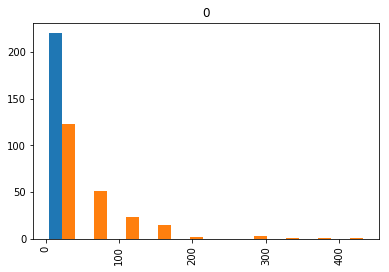

In [49]:
df_spark.hist(['ThumbsUp'],by='churn_event')

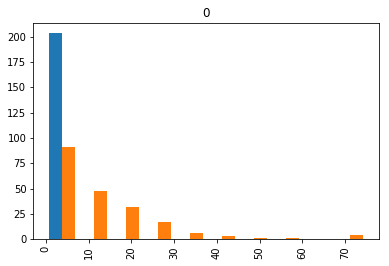

In [52]:
df_spark = spark_data.where(spark_data.page=='Thumbs Down') \
    .groupby(['churn_event','userId']).agg(count(col('page')).alias('ThumbsDown')).orderBy('churn_event').toPandas()
df_spark.hist(['ThumbsDown'],by='churn_event')

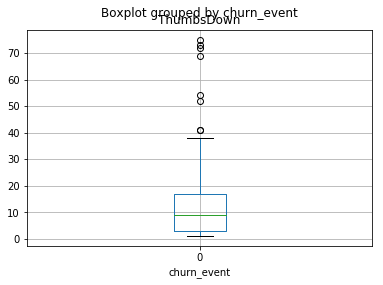

In [53]:
df_spark.boxplot(['ThumbsDown'],by='churn_event')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [10]:
# Total songs listened
feature_1 = spark_data \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
feature_1.describe().show()

+-------+------------------+-----------------+
|summary|            userID|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [11]:
# Sum Thumbs Up
feature_2 = spark_data \
    .select('userID','page') \
    .where(spark_data.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 
feature_2.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [12]:
# Sum Thumbs Down
feature_3 = spark_data \
    .select('userID','page') \
    .where(spark_data.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down') 
feature_3.describe().show()

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [13]:
# Number of Songs in Playlist

feature_4 = spark_data \
    .select('userID','page') \
    .where(spark_data.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_playlist') 
feature_4.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [14]:
# Number of added friends

feature_5 = spark_data \
    .select('userID','page') \
    .where(spark_data.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_friends') 
feature_5.describe().show()

+-------+------------------+------------------+
|summary|            userID|       num_friends|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [15]:
# Total duration of listening
feature_6 = spark_data \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
feature_6.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



In [16]:
# Number of songs listened per session

feature_7 = spark_data.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
feature_7.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [17]:
# Average items in session

feature_8 = spark_data \
    .select('userID','itemInSession') \
    .groupBy('userID') \
    .avg() \
    .withColumnRenamed('avg(count)', 'avg_items_in_session')
feature_8.describe().show()

+-------+------------------+------------------+
|summary|            userID|avg(itemInSession)|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336| 85.26612937155095|
| stddev|105396.47791907164|58.099810332288286|
|    min|                10|               2.5|
|    max|                99| 383.1247511612475|
+-------+------------------+------------------+



In [18]:
# Gender

feature_9 = spark_data \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
feature_9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [19]:
# Time of spark_data
feature_10 = spark_data \
    .select('userId','ts','registration') \
    .withColumn('lifetime',(spark_data.ts-spark_data.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
feature_10.describe().show()


+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [20]:
# Number of artists listened
feature_11 = spark_data \
    .filter(spark_data.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_artist")
feature_11.describe().show()

+-------+------------------+-----------------+
|summary|            userId|       num_artist|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [21]:
# Number of songs listened
feature_12 = spark_data \
    .filter(spark_data.page=="NextSong") \
    .select("userId", "song") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_song")
feature_12.describe().show()

+-------+------------------+-----------------+
|summary|            userId|         num_song|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|897.7911111111111|
| stddev|105396.47791907164|896.3876044550344|
|    min|                10|                3|
|    max|                99|             5946|
+-------+------------------+-----------------+



In [22]:
# Churn class
label = spark_data \
    .select('userId', col('churn_event').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              label|
+-------+------------------+-------------------+
|  count|               277|                277|
|   mean| 68285.25631768953|0.18772563176895307|
| stddev|102130.86452660711|0.39119969301067525|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [23]:
# downgrade_event class
downgrade = spark_data \
    .select('userId', col('downgrade_event').alias('downgrade')) \
    .dropDuplicates()
downgrade.describe().show()

+-------+------------------+-------------------+
|summary|            userId|          downgrade|
+-------+------------------+-------------------+
|  count|               274|                274|
|   mean|  68303.1897810219|0.17883211678832117|
| stddev|106082.31630429266| 0.3839128901757818|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [24]:
# Put everything together

features = feature_1.join(feature_2,'userID','outer') \
    .join(feature_3,'userID','outer') \
    .join(feature_4,'userID','outer') \
    .join(feature_5,'userID','outer') \
    .join(feature_6,'userID','outer') \
    .join(feature_7,'userID','outer') \
    .join(feature_8,'userID','outer') \
    .join(feature_9,'userID','outer') \
    .join(feature_10,'userID','outer') \
    .join(feature_11,'userID','outer') \
    .join(feature_12,'userID','outer') \
    .join(downgrade,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

features.show(5)

+-----------+------------+--------------+------------+-----------+------------------+------------------+------------------+------+------------------+----------+--------+---------+-----+
|total_songs|num_thumb_up|num_thumb_down|num_playlist|num_friends|       listen_time|  avg_songs_played|avg(itemInSession)|gender|          lifetime|num_artist|num_song|downgrade|label|
+-----------+------------+--------------+------------+-----------+------------------+------------------+------------------+------+------------------+----------+--------+---------+-----+
|        381|          17|             5|           7|          4| 66940.89735000003|39.285714285714285| 35.89501312335958|     1|  55.6436574074074|       252|     269|        0|    0|
|        474|          21|             6|           8|          4| 94008.87593999993|              64.5| 60.57805907172996|     0| 70.07462962962963|       339|     378|        0|    0|
|         11|           0|             0|           0|          0|2089

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [25]:
columns = ['total_songs','num_thumb_up','num_thumb_down','num_playlist','num_friends','listen_time','avg_songs_played',\
           'avg(itemInSession)','gender','lifetime','num_artist','num_song','downgrade','label']

assembler = VectorAssembler(inputCols=columns, outputCol="NumFeatures")
features = assembler.transform(features)


In [26]:
features.head()

Row(total_songs=381, num_thumb_up=17, num_thumb_down=5, num_playlist=7, num_friends=4, listen_time=66940.89735000003, avg_songs_played=39.285714285714285, avg(itemInSession)=35.89501312335958, gender=1, lifetime=55.6436574074074, num_artist=252, num_song=269, downgrade=0, label=0, NumFeatures=DenseVector([381.0, 17.0, 5.0, 7.0, 4.0, 66940.8974, 39.2857, 35.895, 1.0, 55.6437, 252.0, 269.0, 0.0, 0.0]))

In [27]:
#Scale Data
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(features)
features = scalerModel.transform(features)
features.show()

+-----------+------------+--------------+------------+-----------+------------------+------------------+------------------+------+------------------+----------+--------+---------+-----+--------------------+--------------------+
|total_songs|num_thumb_up|num_thumb_down|num_playlist|num_friends|       listen_time|  avg_songs_played|avg(itemInSession)|gender|          lifetime|num_artist|num_song|downgrade|label|         NumFeatures|            features|
+-----------+------------+--------------+------------+-----------+------------------+------------------+------------------+------+------------------+----------+--------+---------+-----+--------------------+--------------------+
|        381|          17|             5|           7|          4| 66940.89735000003|39.285714285714285| 35.89501312335958|     1|  55.6436574074074|       252|     269|        0|    0|[381.0,17.0,5.0,7...|[-0.6640027717640...|
|        474|          21|             6|           8|          4| 94008.87593999993|   

In [28]:
train_data, test_data = features.randomSplit([0.6, 0.3], seed=135)

## First we try out a couple of models

Remember, our aim is to maximize F1-Score.

### Logistic Regression

In [29]:
paramGrid = ParamGridBuilder().build()

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8,family="multinomial")


crossval_lr = CrossValidator(estimator=lr,
                          evaluator=evaluator_f1, 
                          estimatorParamMaps=paramGrid,
                          numFolds=2)
start = time()
cvModel_lr = crossval_lr.fit(train_data)
end = time()
print('Training time: {} s'.format(end - start))
results_lr = cvModel_lr.transform(test_data)
print('F-1 Score:{}'.format(evaluator_f1.evaluate(results_lr, {evaluator_f1.metricName: "f1"})))
print('Accuracy: {}'.format(evaluator_f1.evaluate(results_lr, {evaluator_f1.metricName: "accuracy"})))

Training time: 626.6350929737091 s
F-1 Score:0.7040293040293041
Accuracy: 0.7948717948717948


### Random Forest

In [36]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor()
crossval_rf = CrossValidator(estimator=rf,
                          evaluator=evaluator_f1, 
                          estimatorParamMaps=paramGrid,
                          numFolds=2)
start = time()
cvModel_rf = crossval_rf.fit(train_data)
end = time()
print('Training time: {} s'.format(end - start))
results_rf = cvModel_rf.transform(test_data)
print('F-1 Score:{}'.format(evaluator_f1.evaluate(results_rf, {evaluator_f1.metricName: "f1"})))

Training time: 566.9699819087982 s
F-1 Score:0.7856481408817666


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.